In [ ]:
%pip install holoviews
%pip install openradar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import mmwave.dsp as dsp
from mmwave.dsp.utils import Window
from mmwave.dataloader import DCA1000
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation
from scipy.ndimage import maximum_filter
import holoviews as hv
import pywt
import glob
from datetime import datetime as dt
from keras.models import Model, Sequential
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Input, Conv3DTranspose
from keras.callbacks import EarlyStopping
import numpy as np
import imageio.v2 as imageio
from sklearn.model_selection import train_test_split

plt.close("all")

num_frames = 200
num_adc_samples = 256
num_tx_antennas = 2
num_rx_antennas = 4
num_loops_per_frame = 128
num_chirps_per_frame = num_loops_per_frame


num_range_bins = num_adc_samples
num_doppler_bins = num_loops_per_frame
chirp_period = 0.04

range_resolution, bandwidth = dsp.range_resolution(num_adc_samples)
doppler_resolution = dsp.doppler_resolution(bandwidth)

load_data_flag = True

logGabor_flag = False
plot_range_doppler_flag = True

# file_path = 'c:/Users/emirc/Desktop/CodeWorks/mmWare-action-recognition/dataset/right_arm'
# file_path = 'c:/Users/emirc/Desktop/CodeWorks/mmWare-action-recognition/dataset/my_records'
# file_path = 'c:/Users/emirc/Desktop/CodeWorks/mmWare-action-recognition/dataset/testset'
# file_path = 'C:/ti/mmwave_studio_02_01_01_00/mmWaveStudio/PostProc/emir_dataset'-


# bin_files = glob.glob(os.path.join(file_path, '*.bin'))

Mounted at /content/gdrive


In [ ]:
def noise_reduction(det_matrix, num_adc_samples):
    # Wavelet Transform for noise reduction
    coeffs = pywt.wavedec(det_matrix, 'db2', level=4)  # Change wavelet to 'db2'
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=0.2, mode="soft")
    det_matrix = pywt.waverec(coeffs, 'db2')  # Change wavelet to 'db2'

    # Define the scales for the CWT
    scales = np.arange(1, num_adc_samples//2)

    # Perform 2D-FFT
    det_matrix_fft = np.fft.fftshift(np.fft.fft2(det_matrix))

    return det_matrix_fft

In [ ]:
for bin_file in bin_files:
    file_name = os.path.basename(bin_file).split('.')[0]

    # Reading in ADC data
    adc_data = np.fromfile(bin_file, dtype=np.int16)

    adc_data_padded = np.ones(num_frames*4*num_adc_samples*num_chirps_per_frame*2)*1E-8
    adc_data_padded[:adc_data.shape[0]] = adc_data
    adc_data = adc_data_padded.reshape(num_frames, -1)

    adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=num_chirps_per_frame,
                                num_rx=num_rx_antennas, num_samples=num_adc_samples)
    print("Data Loaded!" + file_name)

    dataCube = adc_data

    micro_doppler_data = np.zeros((num_frames, num_loops_per_frame, num_adc_samples), dtype=np.float64)
    fig, ax = plt.subplots()
    prev_det_matrix_fft = None

    frames = []
    for i, frame in enumerate(dataCube):
        # (2) Range Processing
        radar_cube = dsp.range_processing(frame, window_type_1d=Window.BLACKMAN)
        assert radar_cube.shape == (num_chirps_per_frame, num_rx_antennas, num_adc_samples), "[ERROR] Radar cube is not the correct shape!"

        # (3) Doppler Processing
        det_matrix, aoa_input = dsp.doppler_processing(radar_cube, num_tx_antennas=2, clutter_removal_enabled=True, interleaved=False, window_type_2d=Window.HAMMING)

        det_matrix_fft = noise_reduction(det_matrix, num_adc_samples)

        # Frame difference processing
        if prev_det_matrix_fft is not None:
            det_matrix_fft = det_matrix_fft - prev_det_matrix_fft
        prev_det_matrix_fft = det_matrix_fft

        # --- Show output
        det_matrix_vis = np.fft.fftshift(det_matrix, axes=1)

        now = dt.now()
        # Format as a string
        date_string = now.strftime("%Y-%m-%d_%H-%M-%S")
        date_string_2 = now.strftime("%Y-%m-%d_%H-%M")

        write_path = f'c:/Users/emirc/Desktop/CodeWorks/mmWare-action-recognition/frame_images/range_doppler/'
        os.makedirs(write_path, exist_ok=True)

        if plot_range_doppler_flag:
            det_matrix_display = det_matrix_vis

            plt.imshow(det_matrix_display.T, cmap='turbo')
            plt.axis('off')
            # Save the figure
            plt.savefig(f"{write_path}{date_string}.png", bbox_inches='tight', pad_inches=0.1)
            plt.pause(0.2)
            plt.clf()
    #Change the shape of micro_doppler_data to (num_frames, num_adc_samples, num_doppler_bins)
        # micro_doppler_data = np.zeros((num_frames, num_adc_samples, num_doppler_bins), dtype=np.float64)
        # num_frames_in_0_25_sec = int(num_frames * chirp_period * 20)
        # # Now this should work
        # micro_doppler_data[i, :, :] = np.abs(det_matrix_vis)
        # # Save the current frame to the list
        # frames.append([plt.imshow(det_matrix_vis.T, cmap='turbo', animated=True)])
    # Create an animation
    # ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True)

    # write_path = f'c:/Users/emirc/Desktop/CodeWorks/mmWare-action-recognition/frame_images/micro_doppler/'
    # plt.figure()
    # plt.imshow(np.mean(micro_doppler_data[:num_frames_in_0_25_sec], axis=1).T, origin='lower', cmap='turbo',
    #            extent=(0, chirp_period*num_frames_in_0_25_sec, -micro_doppler_data[:, 120, :].shape[1]*doppler_resolution/2, micro_doppler_data[:, 120, :].shape[1]*doppler_resolution/2))
    # plt.title("MicroDoppler Ranges Accumulated")
    # plt.ylabel("Velocity (m/s)")
    # plt.xlabel("Time (seconds)")
    # plt.savefig(f"{write_path}{date_string}.png", bbox_inches='tight', pad_inches=0.25)

    # now = dt.now()

    # # Format as a string
    # date_string = now.strftime("%Y-%m-%d_%H-%M-%S")

    # # Use in filename
    # plt.savefig(f"{write_path}{date_string}.png", bbox_inches='tight', pad_inches=0.25)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of Parkinson's: 1628
Number of Not Parkinson's: 2713


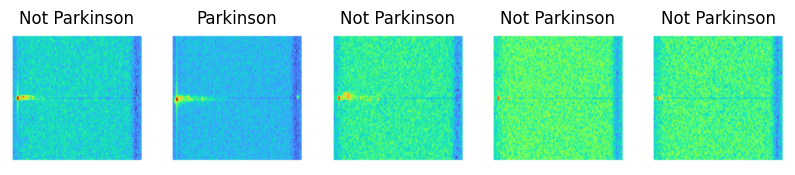

In [ ]:
import os
import numpy as np
import imageio.v2 as imageio
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv3D, MaxPooling3D, Flatten, Reshape, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from google.colab import drive
drive.mount('/content/gdrive')

def load_images_from_folder(folder, label, img_size=(256, 256)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if filepath.endswith(".png") or filepath.endswith(".jpg"):  # Modify to match your image file types
            img = imageio.imread(filepath)
            img = cv2.resize(img, img_size)  # Resize using OpenCV
            images.append(img)
            labels.append(label)  # Assign the label based on the provided argument
    return np.array(images), np.array(labels, dtype=int)

# Define the folder paths
parkinson_folder = "/content/gdrive/MyDrive/range_doppler/parkinson"  # Replace with your actual folder path
not_parkinson_folder = "/content/gdrive/MyDrive/range_doppler/not_parkinson"  # Replace with your actual folder path

# Load images from both folders
X_data_parkinson, y_data_parkinson = load_images_from_folder(parkinson_folder, label=1)
X_data_not_parkinson, y_data_not_parkinson = load_images_from_folder(not_parkinson_folder, label=0)

# Combine the data
X_data = np.concatenate((X_data_parkinson, X_data_not_parkinson), axis=0)
y_data = np.concatenate((y_data_parkinson, y_data_not_parkinson), axis=0)

# Check the loaded data balance
p_count = np.sum(y_data)
np_count = len(y_data) - p_count

print(f"Number of Parkinson's: {p_count}")
print(f"Number of Not Parkinson's: {np_count}")

# Visualize some of the data
def visualize_data(X, y, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X[idx])
        plt.title('Parkinson' if y[idx] == 1 else 'Not Parkinson')
        plt.axis('off')
    plt.show()

visualize_data(X_data, y_data)

In [ ]:
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {y_data.shape}")
print(f"num_sequences: {num_sequences}")
print(f"Expected shape: ({num_sequences}, {sequence_length}, 256, 256, 3)")
print(f"Expected size: {num_sequences * sequence_length * 256 * 256 * 3}")

X_data shape: (4341, 256, 256, 4)
y_data shape: (4341,)
num_sequences: 216
Expected shape: (216, 5, 256, 256, 3)
Expected size: 212336640


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_84 (TimeD  (None, 5, 256, 256, 32)   896       
 istributed)                                                     
                                                                 
 time_distributed_85 (TimeD  (None, 5, 256, 256, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_86 (TimeD  (None, 5, 128, 128, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_87 (TimeD  (None, 5, 128, 128, 64)   18496     
 istributed)                                                     
                                                                 
 time_distributed_88 (TimeD  (None, 5, 128, 128, 64) 

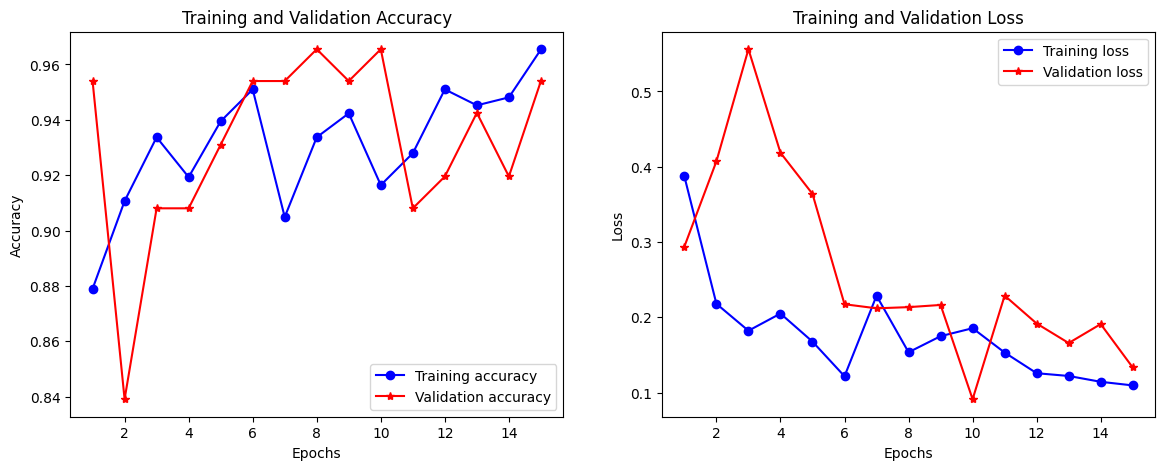

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# Normalize images
X_data = X_data / 255.0

# Extract the first three channels if the image has four channels
X_data = X_data[:, :, :, :3]

# Define sequence length and subsampling rate
sequence_length = 10  # Adjust based on your data
subsampling_rate = 2  # Take every fifth frame

# Create sequences by adding every fifth frame without repeating frames
def create_subsampled_sequences(X, y, seq_length, subsample_rate):
    sequences_X, sequences_y = [], []
    for i in range(0, len(X) - seq_length * subsample_rate + 1, seq_length * subsample_rate):
        sequences_X.append(X[i:i + seq_length * subsample_rate:subsample_rate])
        sequences_y.append(y[i:i + seq_length * subsample_rate:subsample_rate])
    return np.array(sequences_X), np.array(sequences_y)

X_data_seq, y_data_seq = create_subsampled_sequences(X_data, y_data, sequence_length, subsampling_rate)
y_data_seq = np.array([np.bincount(y_seq).argmax() for y_seq in y_data_seq])

# Shuffle sequences
X_data_seq, y_data_seq = shuffle(X_data_seq, y_data_seq, random_state=42)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data_seq, y_data_seq, test_size=0.2, stratify=y_data_seq, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Create the model
def create_model(input_shape):
    model = Sequential()

    # Frame-level model
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    # Sequence-level model
    model.add(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

model = create_model((sequence_length, 256, 256, 3))
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val), class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr, checkpoint], verbose=1)

# Evaluate the model
scores = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {scores[1]*100:.2f}%")

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
# Save the model weights
model.save_weights('model.weights.h5')


OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
input_shape = (sequence_length, 256, 256, 3)  # Adjust based on your image dimensions

# Building the autoencoder
input_img = Input(shape=input_shape)

# Encoder
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling3D((1, 2, 2), padding='same')(x)
x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((1, 2, 2), padding='same')(x)

# Decoder
x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(encoded)
x = Conv3DTranspose(32, (3, 3, 3), strides=(1, 2, 2), activation='relu', padding='same')(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = Conv3DTranspose(3, (3, 3, 3), strides=(1, 2, 2), activation='sigmoid', padding='same')(x)
decoded = Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same')(x)
# Model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# Train the autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), callbacks=[early_stopping])

KeyboardInterrupt: 

In [1]:
import gradio as gr
import numpy as np
import cv2
import os
import imageio
from keras.models import load_model

# Load the pre-trained model
model_path = 'final_model.h5'
model = load_model(model_path)

sequence_length = 10
img_size = (256, 256)

def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize images
        processed_images.append(img)
    processed_images = np.array(processed_images)[:, :, :, :3]  # Ensure 3 channels
    return np.expand_dims(processed_images, axis=0)  # Add batch dimension

def predict(images):
    if len(images) != sequence_length:
        return "Please upload exactly 10 images."
    preprocessed_images = preprocess_images(images)
    prediction = model.predict(preprocessed_images)
    result = "Parkinson" if prediction[0][0] > 0.5 else "Not Parkinson"
    return result

def predict_from_files(files):
    images = [imageio.imread(file.name) for file in files]
    return predict(images)

# Define Gradio interface
inputs = gr.Files(type="filepath", label="Upload 10 Images", file_count="multiple")
outputs = gr.Textbox(label="Prediction")

interface = gr.Interface(
    fn=predict_from_files,
    inputs=inputs,
    outputs=outputs,
    title="Parkinson's Disease Prediction",
    description="Upload a sequence of 10 images to predict Parkinson's Disease."
)

# Launch the app
interface.launch(share=True)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\emirc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TypeError: <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None}.

Exception encountered: Error when deserializing class 'BatchNormalization' using config={'name': 'batch_normalization_46', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}.

Exception encountered: int() argument must be a string, a bytes-like object or a real number, not 'list'